# Coursera - Capstone Project for IBM Data Science Certificate

### The Battle of the Neighborhoods
***

## *Comparing McDonald's Branches in Manhattan and Toronto by Consumer Feedback on FourSquare API*

*by Mohamad Shammaa*



### Install and load libraries

In [1]:

!pip install geopy
!pip install folium
!pip install geocoder

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import seaborn as sns
from bs4 import BeautifulSoup
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files
import geocoder
 
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents
import folium
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 


mpl.style.use('ggplot') # optional: for ggplot-like style



print("Libraries imported.")

Libraries imported.


## Download and manipulate Toronto Data

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dframe = pd.read_html(url, header=0)
df = pd.DataFrame(dframe[0])
df.columns = ['PostalCode', 'Borough', 'Neighborhood']

df = df[df['Borough'] != 'Not assigned'] 
df.drop_duplicates(["PostalCode"], inplace = True)


df.reset_index(drop=True, inplace=True)
for i in df.index:
    if df.iloc[i,2] == "Not assigned":
        df.iloc[i,2] = df.iloc[i,1]
        df.iloc[i,2]

df1 = pd.DataFrame(df, columns=['PostalCode'])
df1['Borough'] = ''
df1['Neighborhood'] = ''

df1.reset_index(drop=True, inplace=True)
for i in df1.index:
    for j in df.index:
        if df1.iloc[i, 0] == df.iloc[j, 0]:
            df1.iloc[i, 1] = df.iloc[j, 1]
            df1.iloc[i, 2] = df1.iloc[i, 2] + ', ' + df.iloc[j, 2]
            
for i in df1.index:
    s = df1.iloc[i,2]
    if s[0] == ',':
        s = s[1:]
    df1.iloc[i,2] = s

### Get the location coordinates and add them to the data of Toronto

In [3]:
def get_latlng(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords


postal_codes = df['PostalCode']    
coords = [ get_latlng(postal_code) for postal_code in postal_codes.tolist() ]


df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

toronto_df =df


toronto_df = toronto_df.drop("PostalCode",axis = 1)
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_df['Borough'].unique()),
        toronto_df.shape[0]
    )
)

toronto_df.head()

The dataframe has 11 boroughs and 103 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.752440,-79.329271
1,North York,Victoria Village,43.730421,-79.313320
2,Downtown Toronto,Harbourfront,43.655120,-79.362640
3,North York,Lawrence Heights,43.723125,-79.451589
4,Queen's Park,Queen's Park,43.661102,-79.391035


## Download and prepare New York Data

Download New York Data: https://geo.nyu.edu/download/file/nyu-2451-34572-geojson.json

In [5]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')


print('Loading data...')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    


Data downloaded!
Loading data...


In [6]:
neighborhoods_ny = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Take only neighborhoods from manhattan!
neighborhoods_m = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_m.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


## Visualize the Neighborhoods of Toronto and Manhattan using Folium

### Get the geographical coordination of both cities

In [7]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
m_latitude = location.latitude
m_longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(m_latitude, m_longitude))

address = 'Toronto'

location = geolocator.geocode(address)
to_latitude = location.latitude
to_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(to_latitude, to_longitude))


The geograpical coordinate of New York are 40.7900869, -73.9598295.
The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Append both data frames

In [8]:
df = neighborhoods_m.append(toronto_df, True)
pd.set_option('max_rows', 8)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
...,...,...,...,...
139,Downtown Toronto,Church and Wellesley,43.666585,-79.381302
140,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.648690,-79.385440
141,Etobicoke,Humber Bay,43.632765,-79.489601
142,Etobicoke,Kingsway Park South West,43.624630,-79.526950


### Visualize all Neighborhoods

In [9]:
# creating map of Toronto using latitude and longitude values
toronto_map = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)

for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

In [10]:
# creating map of Manhattan using latitude and longitude values
map_newyork = folium.Map(location=[m_latitude, m_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_m['Latitude'], neighborhoods_m['Longitude'], neighborhoods_m['Borough'], neighborhoods_m['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Locate both cities on the world map

In [11]:

T_N_map = folium.Map(location=[((m_latitude + to_latitude)/2), ((m_longitude + to_longitude)/2)], zoom_start=7, width='100%', height='100%')

for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='gold',
        fill_opacity=0.7).add_to(T_N_map)
     
    
T_N_map

## Use Foursquare API to explore McDonalds restaurants in the neighborhoods 

In [12]:
CLIENT_ID = 'IWWC3B25EGD5SWXVMKBTNLKSOKGYBFRYCQWXOR3GDTBPMBGG' # your Foursquare ID
CLIENT_SECRET = 'PVD1S4ZXBY2CKEZJBXQRKYMCL4HUBNS2S1SW3EL5FL22JN0M' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IWWC3B25EGD5SWXVMKBTNLKSOKGYBFRYCQWXOR3GDTBPMBGG
CLIENT_SECRET:PVD1S4ZXBY2CKEZJBXQRKYMCL4HUBNS2S1SW3EL5FL22JN0M


## Search for Mcdonalds branches within a radius of 5000 meters:

### Set the search criteria

In [13]:
search_query = 'Mcdonalds'
radius = 5000
print(search_query + ' .... OK!')

Mcdonalds .... OK!


### Mcdonalds branches in Toronto within a radius of 5000 meters

In [14]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, to_latitude, to_longitude, VERSION, search_query, radius, LIMIT)

results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head(2)

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",False,5293ebf411d2f044f678efd8,356 Yonge St,CA,Toronto,Canada,at Elm St.,637,"[356 Yonge St (at Elm St.), Toronto ON M5B 1S5...","[{'label': 'display', 'lat': 43.658196096689, ...",43.658196,-79.381872,M5B 1S5,ON,McDonald's,v-1567164412
1,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",False,4c89267412e4bfb7731fab32,123 Yonge St,CA,Toronto,Canada,at Adelaide St.,765,"[123 Yonge St (at Adelaide St.), Toronto ON M5...","[{'label': 'display', 'lat': 43.65078264244489...",43.650783,-79.378778,M5C 1W4,ON,McDonald's,v-1567164412


In [15]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head(2)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,McDonald's,Fast Food Restaurant,356 Yonge St,CA,Toronto,Canada,at Elm St.,637,"[356 Yonge St (at Elm St.), Toronto ON M5B 1S5...","[{'label': 'display', 'lat': 43.658196096689, ...",43.658196,-79.381872,M5B 1S5,ON,5293ebf411d2f044f678efd8
1,McDonald's,Fast Food Restaurant,123 Yonge St,CA,Toronto,Canada,at Adelaide St.,765,"[123 Yonge St (at Adelaide St.), Toronto ON M5...","[{'label': 'display', 'lat': 43.65078264244489...",43.650783,-79.378778,M5C 1W4,ON,4c89267412e4bfb7731fab32


In [16]:
t_data = dataframe_filtered[dataframe_filtered['city']=='Toronto']#drop cities other than Toronto
t_data1 = t_data[t_data['categories']=='Fast Food Restaurant']#drop categories other than Fast Food
t_data_filtered = t_data1[t_data1.city != "nan"]#drop data with 'nan'
t_data_filtered.drop_duplicates(["id"], inplace = True) #drop rows with same id & address
t_data_filtered.drop_duplicates(["address"], inplace = True) 
t_data_filtered.head(2)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,McDonald's,Fast Food Restaurant,356 Yonge St,CA,Toronto,Canada,at Elm St.,637,"[356 Yonge St (at Elm St.), Toronto ON M5B 1S5...","[{'label': 'display', 'lat': 43.658196096689, ...",43.658196,-79.381872,M5B 1S5,ON,5293ebf411d2f044f678efd8
1,McDonald's,Fast Food Restaurant,123 Yonge St,CA,Toronto,Canada,at Adelaide St.,765,"[123 Yonge St (at Adelaide St.), Toronto ON M5...","[{'label': 'display', 'lat': 43.65078264244489...",43.650783,-79.378778,M5C 1W4,ON,4c89267412e4bfb7731fab32


In [17]:
# filter columns
filtered_columns = ['name', 'city', 'address', 'lat', 'lng', 'id']
mcd_br_t =t_data_filtered.loc[:, filtered_columns]

mcd_br_t.head(2)

,name,city,address,lat,lng,id
0,McDonald's,Toronto,356 Yonge St,43.658196,-79.381872,5293ebf411d2f044f678efd8
1,McDonald's,Toronto,123 Yonge St,43.650783,-79.378778,4c89267412e4bfb7731fab32


### Mcdonalds branches in Manhattan, New York within a radius of 5000 meters

In [18]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, m_latitude, m_longitude, VERSION, search_query, radius, LIMIT)

results = requests.get(url).json()
results

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

m_data = dataframe_filtered[dataframe_filtered['city']=='New York']
m_data1 = m_data[m_data['categories']=='Fast Food Restaurant']
m_data_filtered = m_data1[m_data1.city != "nan"]
m_data_filtered.drop_duplicates(["id"], inplace = True)
m_data_filtered.drop_duplicates(["address"], inplace = True)
m_data_filtered.drop("city", axis = 1)
m_data_filtered['city'] = 'Manhattan, NY'

# filter columns
filtered_columns = ['name', 'city', 'address', 'lat', 'lng', 'id']
mcd_br_m =m_data_filtered.loc[:, filtered_columns]
mcd_br_m.head(2)

,name,city,address,lat,lng,id
0,McDonald's,"Manhattan, NY",2549 Broadway,40.794389,-73.972343,4b410addf964a520f4bf25e3
1,McDonald's,"Manhattan, NY",1872 3rd Ave,40.789984,-73.946077,4b9ad23ef964a52006d935e3


### Visualize McDonald's branches in both Toronto and Manhattan

In [19]:
# McDonald's branches in Toronto (label = street name)
mcd_t = folium.Map(location=[to_latitude, to_longitude], zoom_start=13) 

for lat, lng, label in zip(mcd_br_t.lat, mcd_br_t.lng, mcd_br_t.address):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='gold',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(mcd_t)

# display map
mcd_t

In [20]:
# McDonald's branches in Manhattan (label = street name)
mcd_m = folium.Map(location=[m_latitude, m_longitude], zoom_start=12) 

for lat, lng, label in zip(mcd_br_m.lat, mcd_br_m.lng, mcd_br_m.address):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='gold',
        popup=str(label),
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(mcd_m)

# display map
mcd_m

### Get the number of total likes and the ratings for the studied branches and assign them to a list:

### Do not Run it 

like_list_t = []
json_list_t = []

for id in mcd_br_t['id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    likes = result['response']['venue']['likes']['count']
    like_list_t.append(likes)
    
    
print(like_list_t)



        


for id in mcd_br_t['id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        print(result['response']['venue']['rating'])
    except:
        print('na')

rating_list_m = []
like_list_m = []
json_list_m = []

for id in mcd_br_m['id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    
    likes = result['response']['venue']['likes']['count']
    like_list_m.append(likes)
    
    ratings = result['response']['venue']['rating']
    rating_list_m.append(ratings)
    
print(like_list_m)
print(rating_list_m)

#mcd_br_m['likes'] = like_list_m
#mcd_br_m['ratings'] = rating_list_m
#mcd_br_m.head()

### Enter the results manualy (p.s. the results might change daily)

In [21]:
#Toronto
mcd_br_t['likes'] = [56, 27, 43, 24, 22, 17, 26, 3, 1, 8, 1, 6, 11, 0, 6, 0, 1, 26, 19, 4, 15, 18, 3, 18, 14, 16, 9, 2, 6, 7, 17, 0, 0, 27, 0, 0, 2, 6, 6, 0]
mcd_br_t['ratings'] = [6.5,5.1,5.4,5.7,6.3,5.7,5.4,5.1,5.7,5.0,'na',5.7,4.9,5.8,5.3,5.8,5.9,5.7,5.0,4.6,4.9,5.4,5.0,5.4,4.9,6.2,5.7,6.0,5.1,5.2,5.4,5.4,5.8,5.6,'na',5.8,4.7,4.9,5.0,'na']
mcd_br_t['ratings'] = mcd_br_t['ratings'].replace({'na':np.nan}) 
mcd_br_t = mcd_br_t[np.isfinite(mcd_br_t['ratings'])] # drop rows with unknown rating
mcd_br_t.reset_index(drop = True, inplace = True)
mcd_br_t.head(2)

,name,city,address,lat,lng,id,likes,ratings
0,McDonald's,Toronto,356 Yonge St,43.658196,-79.381872,5293ebf411d2f044f678efd8,56,6.5
1,McDonald's,Toronto,123 Yonge St,43.650783,-79.378778,4c89267412e4bfb7731fab32,27,5.1


In [22]:
#Manhattan
mcd_br_m['likes'] = [26, 17, 57, 21, 61, 122, 47, 27, 10, 66, 202, 47, 105, 12, 58, 19, 7, 26, 6, 35, 45, 60, 51, 269, 38, 21, 67, 23, 66, 14, 19, 25, 12, 19, 12, 1, 43, 24, 22, 12, 0]
mcd_br_m['ratings'] = [5.3, 6.1, 5.5, 5.1, 5.5, 6.2, 5.4, 5.4, 4.9, 6.2, 6.2, 5.5, 5.4, 4.7, 5.6, 4.9, 6.2, 5.2, 4.9, 5.7, 5.3, 5.8, 5.5, 6.3, 5.2, 5.0, 5.3, 5.2, 6.3, 5.1, 6.0, 5.4, 5.1, 5.3, 5.3, 5.8, 5.6, 5.1, 4.8, 5.0, 5.1]

mcd_br_m.reset_index(drop = True, inplace = True)
mcd_br_m.head(2)

,name,city,address,lat,lng,id,likes,ratings
0,McDonald's,"Manhattan, NY",2549 Broadway,40.794389,-73.972343,4b410addf964a520f4bf25e3,26,5.3
1,McDonald's,"Manhattan, NY",1872 3rd Ave,40.789984,-73.946077,4b9ad23ef964a52006d935e3,17,6.1


In [23]:
#Sort Toronto data by number of likes
mcd_br_t.sort_values(by='likes', ascending=False, inplace=True)
mcd_br_t.reset_index(drop = True, inplace = True)

In [24]:
#Sort Manhattan data by number of likes
mcd_br_m.sort_values(by='likes', ascending=False, inplace=True)
mcd_br_m.reset_index(drop = True, inplace = True)

In [25]:
print('number of studied McDonalds branches in Toronto are:', mcd_br_t.name.count())
print('number of studied McDonalds branches in Manhattan(NY) are:', mcd_br_m.name.count())

number of studied McDonalds branches in Toronto are: 37
number of studied McDonalds branches in Manhattan(NY) are: 41


### Descriptive statistics for total likes & ratings in each City

In [26]:
pd.set_option('max_rows', 10)
mcd_br_t['likes'].describe()

count    37.000000
mean     12.594595
std      12.680824
min       0.000000
25%       3.000000
50%       8.000000
75%      18.000000
max      56.000000
Name: likes, dtype: float64

In [27]:
mcd_br_m['likes'].describe()

count     41.000000
mean      44.243902
std       51.725130
min        0.000000
25%       17.000000
50%       26.000000
75%       57.000000
max      269.000000
Name: likes, dtype: float64

In [28]:
mcd_br_t['ratings'].describe()

count    37.000000
mean      5.432432
std       0.457684
min       4.600000
25%       5.000000
50%       5.400000
75%       5.700000
max       6.500000
Name: ratings, dtype: float64

In [29]:
mcd_br_m['ratings'].describe()

count    41.000000
mean      5.448780
std       0.447282
min       4.700000
25%       5.100000
50%       5.400000
75%       5.700000
max       6.300000
Name: ratings, dtype: float64

In [30]:
# Prepare format for seaborn boxplots
sns.set()
sns.set(rc={'figure.figsize':(8,5)})

In [31]:
# Merging data
df_both = pd.concat([mcd_br_t, mcd_br_m]).reset_index(drop=True)
pd.set_option('max_rows', 4)
df_both

,name,city,address,lat,lng,id,likes,ratings
0,McDonald's,Toronto,356 Yonge St,43.658196,-79.381872,5293ebf411d2f044f678efd8,56,6.5
1,McDonald's,Toronto,160 Spadina Ave.,43.648747,-79.396460,4ae1b6d8f964a520ed8621e3,43,5.4
...,...,...,...,...,...,...,...,...
76,McDonald's,"Manhattan, NY",809-811 8th Ave,40.747569,-73.997088,4b1331eef964a5205c9523e3,1,5.8
77,McDonald's,"Manhattan, NY",3809 Broadway,40.835319,-73.944335,4e4e0e89bd4101d0d7a13250,0,5.1


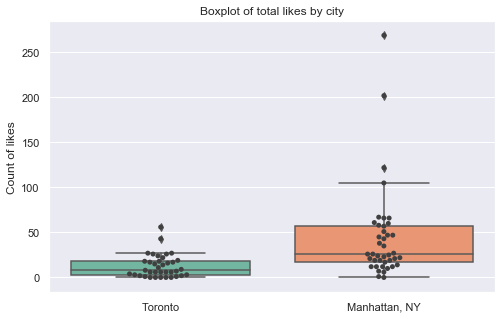

In [32]:
# boxplot for likes in both cities
ax=sns.boxplot(x="city", y="likes", data=df_both, palette="Set2")
ax=sns.swarmplot(x="city", y="likes", data=df_both, color=".25")
ax.set_title('Boxplot of total likes by city')
ax.set_ylabel('Count of likes')
ax.set_xlabel('');

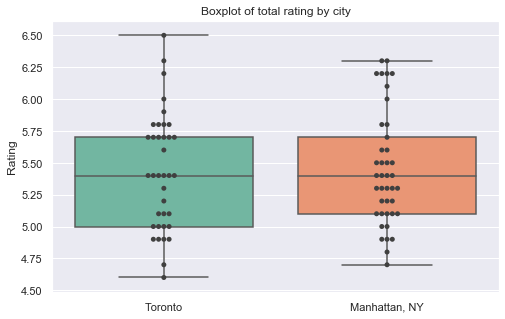

In [33]:
# box plot for ratings in both cities
ax = sns.boxplot(x="city", y="ratings", data=df_both, palette="Set2")
ax = sns.swarmplot(x="city", y="ratings", data=df_both, color=".25")
ax.set_title('Boxplot of total rating by city')
ax.set_ylabel('Rating')
ax.set_xlabel('');

###  Plot the frequency of likes as categories

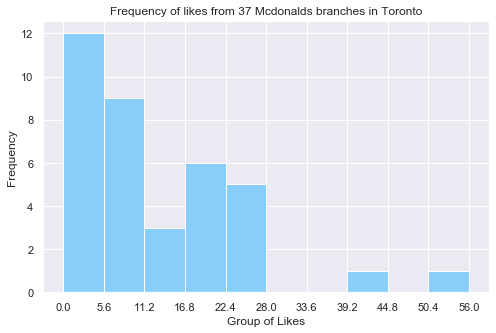

In [34]:
# Plot the frequency of likes in Toronto in ten categories

count, bin_edges = np.histogram(mcd_br_t['likes'])

mcd_br_t['likes'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges, color='lightskyblue')

plt.title("Frequency of likes from 37 Mcdonalds branches in Toronto") # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Group of Likes') # add x-label

plt.show()

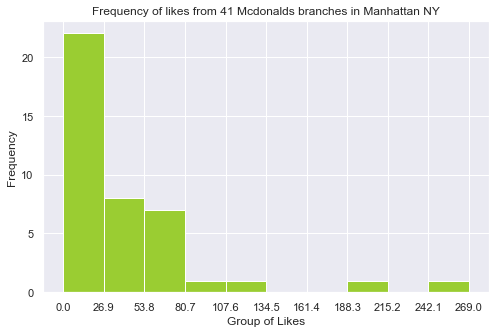

In [35]:
# Plot the frequency of likes in Manhattan in ten categories

count, bin_edges = np.histogram(mcd_br_m['likes'])

mcd_br_m['likes'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges, color = 'yellowgreen')

plt.title("Frequency of likes from 41 Mcdonalds branches in Manhattan NY") # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Group of Likes') # add x-label

plt.show()

# Clustering using K-Means method

### Prepare data for Clustering

In [36]:
# Drop unnecessary columns 
mcd_br_t_2 = mcd_br_t.drop(['name', 'city', 'address', 'id'], axis=1)
mcd_br_m_2 = mcd_br_m.drop(['name', 'city', 'address', 'id'], axis=1)

In [37]:
mcd_br_t_2.head(1)

,lat,lng,likes,ratings
0,43.658196,-79.381872,56,6.5


In [38]:
mcd_br_m_2.head(1)

,lat,lng,likes,ratings
0,40.765888,-73.957161,269,6.3


### Clustering & Visualizing Clusters for each City 

## 1. Toronto

In [39]:
kclusters = 4 # set the number of clusters
k_means = KMeans(n_clusters=kclusters, random_state=0, init = 'k-means++', n_init = 15).fit(mcd_br_t_2) # fit the model
Clusters = k_means.labels_
mcd_br_t['Cluster'] = Clusters # add result column to the original data

In [40]:
# Function to sort clustors best to worst
def conditions(n):
    if n['Cluster']==3:
        return 1
    if n['Cluster']==1:
        return 2
    if n['Cluster']==2:
        return 3
    if n['Cluster']==0:
        return 4

mcd_br_t['cluster_sorted']=mcd_br_t.apply(conditions, axis=1)

In [41]:
import folium
import matplotlib.colors as colors
mcd_t = folium.Map(location=[to_latitude, to_longitude], zoom_start=13) 

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []

for lat, lon, add, cluster in zip(mcd_br_t['lat'], mcd_br_t['lng'], mcd_br_t['address'], mcd_br_t['cluster_sorted']):
    label = folium.Popup(str(add) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.8).add_to(mcd_t)
       
mcd_t

### Results for Toronto

In [42]:
pd.set_option('max_rows', 100)
#### Cluster 1
mcd_br_t.loc[mcd_br_t['cluster_sorted'] == 1, mcd_br_t.columns[[2] + list(range(6, mcd_br_t.shape[1]))]]

,address,likes,ratings,Cluster,cluster_sorted
0,356 Yonge St,56,6.5,3,1
1,160 Spadina Ave.,43,5.4,3,1


In [43]:
#### Cluster 2
mcd_br_t.loc[mcd_br_t['cluster_sorted'] == 2, mcd_br_t.columns[[2] + list(range(6, mcd_br_t.shape[1]))]]

,address,likes,ratings,Cluster,cluster_sorted
2,2365 Dundas St W,27,5.6,1,2
3,123 Yonge St,27,5.1,1,2
4,127 Church St.,26,5.4,1,2
5,200 Front St. W,26,5.7,1,2
6,470 Yonge St.,24,5.7,1,2
7,220 Yonge St,22,6.3,1,2


In [44]:
#### Cluster 3
mcd_br_t.loc[mcd_br_t['cluster_sorted'] == 3, mcd_br_t.columns[[2] + list(range(6, mcd_br_t.shape[1]))]]

,address,likes,ratings,Cluster,cluster_sorted
8,61 Front St. W.,19,5.0,2,3
9,345 Bloor Street East,18,5.4,2,3
10,1045 Pape Ave,18,5.4,2,3
11,595 Bay St,17,5.7,2,3
12,28 Eglinton Ave. E.,17,5.4,2,3
13,1000 Gerrard St E,16,6.2,2,3
14,1221 King St. W,15,4.9,2,3
15,109 McCaul St.,14,4.9,2,3
16,181 Bay St.,11,4.9,2,3


In [45]:
#### Cluster 4
mcd_br_t.loc[mcd_br_t['cluster_sorted'] == 4, mcd_br_t.columns[[2] + list(range(6, mcd_br_t.shape[1]))]]

,address,likes,ratings,Cluster,cluster_sorted
17,10 The Queensway,9,5.7,0,4
18,100 Wellington St,8,5.0,0,4
19,11 St. Clair Ave. E.,7,5.2,0,4
20,"Toronto, ON",6,5.1,0,4
21,98 Danforth Ave.,6,4.9,0,4
22,885 Bloor St West,6,5.0,0,4
23,123 Queen St. West,6,5.3,0,4
24,192A Bloor St W,6,5.7,0,4
25,833 Bloor Street West,4,4.6,0,4
26,29-31 Woodward Ave.,3,5.0,0,4


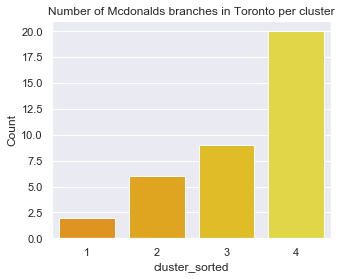

In [46]:
sns.set(rc={'figure.figsize':(5,4)})
toronto_br_grouped_count = mcd_br_t.groupby('cluster_sorted')['address'].count().to_frame()
toronto_br_grouped_count.reset_index(inplace=True)
ax = sns.barplot(x='cluster_sorted', y='address', data=toronto_br_grouped_count, palette="Wistia_r")
ax.set_title('Number of Mcdonalds branches in Toronto per cluster')
ax.set_ylabel('Count');

## 2. Manhattan

In [47]:
kclusters=4
k_means = KMeans(n_clusters=kclusters, random_state=0, init = 'k-means++', n_init = 15).fit(mcd_br_m_2)
Clusters = k_means.labels_
mcd_br_m['Cluster'] = Clusters

In [48]:
# Function to sort clustors best to worst
def conditions(n):
    if n['Cluster']==0:
        return 1
    if n['Cluster']==3:
        return 2
    if n['Cluster']==2:
        return 3
    if n['Cluster']==1:
        return 4

mcd_br_m['cluster_sorted']=mcd_br_m.apply(conditions, axis=1) # Sort clusters



In [49]:
import folium
import matplotlib.colors as colors
mcd_m = folium.Map(location=[m_latitude, m_longitude], zoom_start=12) 

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []

for lat, lon, add, cluster in zip(mcd_br_m['lat'], mcd_br_m['lng'], mcd_br_m['address'], mcd_br_m['cluster_sorted']):
    label = folium.Popup(str(add) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.8).add_to(mcd_m)
       
mcd_m

In [50]:
#### Cluster 1
mcd_br_m.loc[mcd_br_m['cluster_sorted'] == 1, mcd_br_m.columns[[2] + list(range(6, mcd_br_m.shape[1]))]]

,address,likes,ratings,Cluster,cluster_sorted
0,1286 1st Ave,269,6.3,0,1
1,1651 Broadway,202,6.2,0,1


In [51]:
#### Cluster 2
mcd_br_m.loc[mcd_br_m['cluster_sorted'] == 2, mcd_br_m.columns[[2] + list(range(6, mcd_br_m.shape[1]))]]

,address,likes,ratings,Cluster,cluster_sorted
2,2726 Broadway,122,6.2,3,2
3,1871 2nd Ave,105,5.4,3,2


In [52]:
#### Cluster 3
mcd_br_m.loc[mcd_br_m['cluster_sorted'] == 3, mcd_br_m.columns[[2] + list(range(6, mcd_br_m.shape[1]))]]

,address,likes,ratings,Cluster,cluster_sorted
4,429 7th Ave,67,5.3,2,3
5,556 Fashion Ave,66,6.2,2,3
6,14 E 47th St,66,6.3,2,3
7,1499 3rd Ave,61,5.5,2,3
8,809 Avenue of the Americas,60,5.8,2,3
9,220 W 42nd St,58,5.6,2,3
10,2049 Broadway,57,5.5,2,3
11,39 Union Sq W,51,5.5,2,3
12,966 3rd Ave,47,5.5,2,3
13,600 W 125th St,47,5.4,2,3


In [53]:
#### Cluster 4
mcd_br_m.loc[mcd_br_m['cluster_sorted'] == 4, mcd_br_m.columns[[2] + list(range(6, mcd_br_m.shape[1]))]]

,address,likes,ratings,Cluster,cluster_sorted
17,1188 Avenue of the Americas,35,5.7,1,4
18,490 8th Ave,27,5.4,1,4
19,2549 Broadway,26,5.3,1,4
20,2142 3rd Ave,26,5.2,1,4
21,2379 Adam Clayton Powell Jr Blvd,25,5.4,1,4
22,3410 Broadway,24,5.1,1,4
23,972 Avenue of the Americas,23,5.2,1,4
24,686 Avenue of the Americas,22,4.8,1,4
25,1560 Broadway,21,5.0,1,4
26,354 W 125th St,21,5.1,1,4


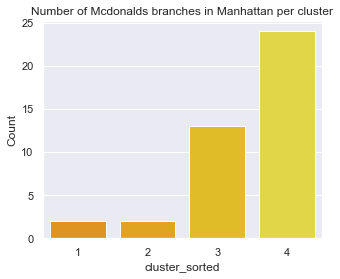

In [54]:
sns.set(rc={'figure.figsize':(5,4)})
manhattan_br_grouped_count = mcd_br_m.groupby('cluster_sorted')['address'].count().to_frame()
manhattan_br_grouped_count.reset_index(inplace=True)
ax = sns.barplot(x='cluster_sorted', y='address', data=manhattan_br_grouped_count, palette="Wistia_r")
ax.set_title('Number of Mcdonalds branches in Manhattan per cluster')
ax.set_ylabel('Count');

## Clustering both Cities together

In [55]:
both_C = df_both.drop(['name', 'city', 'address', 'id'], axis=1)# drop some Columns

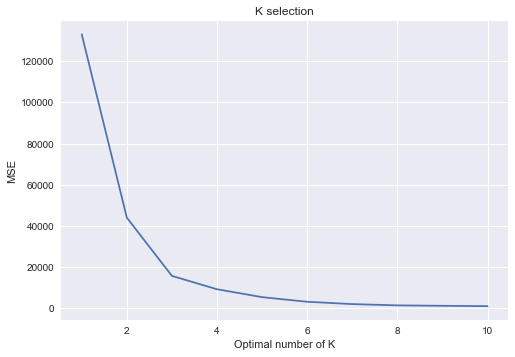

In [56]:
#Find optimal number of clusters and visualize it

plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'k-means++', n_init = 15).fit(both_C)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Optimal number of K")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [57]:
kclusters = 3
k_means = KMeans(n_clusters=kclusters, random_state=0, init = 'k-means++', n_init = 15).fit(both_C)
Clusters = k_means.labels_
df_both['Cluster'] = Clusters
df_clustered = df_both.drop(['name', 'lat', 'lng', 'id'], axis=1)# dropping Columns
pd.set_option('max_rows', 2)
df_clustered

,city,address,likes,ratings,Cluster
0,Toronto,356 Yonge St,56,6.5,0
...,...,...,...,...,...
77,"Manhattan, NY",3809 Broadway,0,5.1,1


In [58]:
# Function to sort clustors best to worst
def conditions(n):
    if n['Cluster']==2:
        return 1
    if n['Cluster']==0:
        return 2
    if n['Cluster']==1:
        return 3

df_clustered['cluster_sorted']=df_clustered.apply(conditions, axis=1) # Sort clusters

In [59]:
pd.set_option('max_rows', 100)
#### Cluster 1
df_clustered.loc[df_clustered['cluster_sorted'] == 1]

,city,address,likes,ratings,Cluster,cluster_sorted
37,"Manhattan, NY",1286 1st Ave,269,6.3,2,1
38,"Manhattan, NY",1651 Broadway,202,6.2,2,1


In [60]:
#### Cluster 2
df_clustered.loc[df_clustered['cluster_sorted'] == 2]

,city,address,likes,ratings,Cluster,cluster_sorted
0,Toronto,356 Yonge St,56,6.5,0,2
1,Toronto,160 Spadina Ave.,43,5.4,0,2
39,"Manhattan, NY",2726 Broadway,122,6.2,0,2
40,"Manhattan, NY",1871 2nd Ave,105,5.4,0,2
41,"Manhattan, NY",429 7th Ave,67,5.3,0,2
42,"Manhattan, NY",556 Fashion Ave,66,6.2,0,2
43,"Manhattan, NY",14 E 47th St,66,6.3,0,2
44,"Manhattan, NY",1499 3rd Ave,61,5.5,0,2
45,"Manhattan, NY",809 Avenue of the Americas,60,5.8,0,2
46,"Manhattan, NY",220 W 42nd St,58,5.6,0,2


In [61]:
#### Cluster 3
df_clustered.loc[df_clustered['cluster_sorted'] == 3]

,city,address,likes,ratings,Cluster,cluster_sorted
2,Toronto,2365 Dundas St W,27,5.6,1,3
3,Toronto,123 Yonge St,27,5.1,1,3
4,Toronto,127 Church St.,26,5.4,1,3
5,Toronto,200 Front St. W,26,5.7,1,3
6,Toronto,470 Yonge St.,24,5.7,1,3
7,Toronto,220 Yonge St,22,6.3,1,3
8,Toronto,61 Front St. W.,19,5.0,1,3
9,Toronto,345 Bloor Street East,18,5.4,1,3
10,Toronto,1045 Pape Ave,18,5.4,1,3
11,Toronto,595 Bay St,17,5.7,1,3


In [62]:
#### Cluster 4
df_clustered.loc[df_clustered['Cluster'] == 3]

,city,address,likes,ratings,Cluster,cluster_sorted


### Count & visualize the total number of Mcdonalds branches per cluster

In [63]:
df_clus_count = pd.DataFrame(df_clustered['cluster_sorted'].value_counts())
df_clus_count = df_clus_count.reset_index()
df_clus_count.columns = ['cluster_sorted', 'Count']
df_clus_count

,cluster_sorted,Count
0,3,59
1,2,17
2,1,2


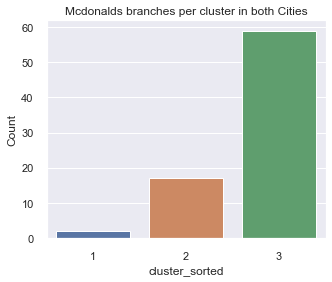

In [64]:
sns.set(rc={'figure.figsize':(5,4)}) 
ax = sns.barplot(x='cluster_sorted', y='Count', data=df_clus_count)
ax.set_title('Mcdonalds branches per cluster in both Cities');

### We should know the distribution of the cities in each cluster so we need to create a pivot table

In [65]:
df_final = df_clustered.copy()
df_final['count'] = 1 # adding count column
pivot = pd.pivot_table(df_final, index=["cluster_sorted","city"], values=["count"], aggfunc=np.sum)
pivot

count
cluster_sorted city                
1              Manhattan, NY      2
2              Manhattan, NY     15
               Toronto            2
3              Manhattan, NY     24
               Toronto           35

Text(0.5, 1.0, 'Count of branches per clusters by city')

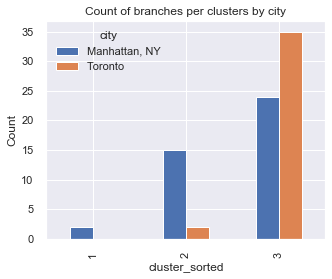

In [66]:
df_final.groupby('cluster_sorted')['city']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=False)

plt.ylabel('Count')
plt.title('Count of branches per clusters by city')


### Add a column describes the level of performance depending on the quantile values of likes

In [67]:
df_final['likes'].describe()

count     78.000000
mean      29.230769
std       41.449366
min        0.000000
25%        6.250000
50%       18.500000
75%       33.000000
max      269.000000
Name: likes, dtype: float64

In [68]:
poor = df_final['likes']<=7
below_avg = df_final[(df_final['likes']>7) & (df_final['likes']<=19)]
abv_avg = df_final[(df_final['likes']>19) & (df_final['likes']<=34)]
good = df_final[(df_final['likes']>34) & (df_final['likes']<=100)]
very_good = df_final[(df_final['likes']>100) & (df_final['likes']<=150)]
great = df_final['likes']>150
def conditions(n):
    if n['likes']<=7:
        return 'poor'
    if n['likes']<=19:
        return 'below avg'
    if n['likes']<=34:
        return 'abv avg'
    if n['likes']<=100:
        return 'good'
    if n['likes']<=150:
        return 'very good'
    if n['likes']>150:
        return 'great'

df_final['level of performance']=df_final.apply(conditions, axis=1)

In [69]:
# Add sorting column 
def conditions(n):
    if n['level of performance']=='poor':
        return '6'
    if n['level of performance']=='below avg':
        return '5'
    if n['level of performance']=='abv avg':
        return '4'
    if n['level of performance']=='good':
        return '3'
    if n['level of performance']=='very good':
        return '2'
    if n['level of performance']=='great':
        return '1'

df_final['sorting']=df_final.apply(conditions, axis=1)

In [70]:
pivot2 = pd.pivot_table(df_final, index=["level of performance", "sorting"], values=["count"], aggfunc=np.sum)
pivot2.sort_values(by='sorting', ascending=True, inplace=True)
pivot2.reset_index(drop=False, inplace=True)
pivot2.drop(['sorting'], axis=1, inplace=True)
pivot2.set_index('level of performance', inplace=True)
pivot2

,count
level of performance,
great,2
very good,2
good,16
abv avg,15
below avg,21
poor,22


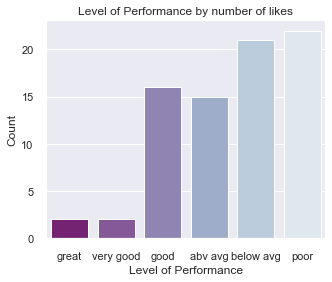

In [71]:
pivot2.reset_index(drop=False, inplace=True)
sns.set(rc={'figure.figsize':(5,4)})
ax = sns.barplot(x='level of performance', y='count', data=pivot2, palette="BuPu_r")
ax.set_title('Level of Performance by number of likes')
ax.set_ylabel('Count')
ax.set_xlabel('Level of Performance');



In [72]:
# show resulty per City
pivot3 = pd.pivot_table(df_final, index=["level of performance", "city", "sorting"], values=["count"], aggfunc=np.sum)
pivot3.sort_values(by='sorting', ascending=True, inplace=True)
pivot3.reset_index(drop=False, inplace=True)
pivot3.drop(['sorting'], axis=1, inplace=True)
pivot3.set_index(['level of performance','city'], inplace=True)
pivot3

count
level of performance city                
great                Manhattan, NY      2
very good            Manhattan, NY      2
good                 Manhattan, NY     14
                     Toronto            2
abv avg              Manhattan, NY      9
                     Toronto            6
below avg            Manhattan, NY     10
                     Toronto           11
poor                 Manhattan, NY      4
                     Toronto           18

In [73]:
pivot3.reset_index(drop=False, inplace=True)
df_final.sort_values(by='likes', ascending=False, inplace=True)

Text(0.5, 1.0, 'Count of branches per performance category and by city')

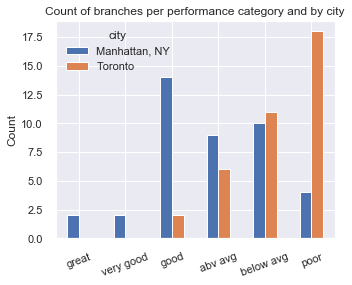

In [74]:
df_final.groupby('sorting')['city']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=False)

plt.xticks(np.arange(6), ('great', 'very good', 'good', 'abv avg', 'below avg', 'poor'), rotation=20)
plt.xlabel('')
plt.ylabel('Count')
plt.title('Count of branches per performance category and by city')

In [75]:
pd.set_option('max_rows', 100)
df_final.drop(['sorting'], axis=1, inplace=True)
# sorting
df_final.sort_values(by='likes', ascending=False, inplace=True)
df_final.reset_index(drop=True, inplace=True)
top= df_final.head(20)
worst= df_final.tail(20)

In [76]:
pivot4 = pd.pivot_table(df_final, index=["city", "address", "likes", "ratings", "level of performance", "cluster_sorted"], values=["count"], aggfunc=np.sum)
pivot4.sort_values(by='likes', ascending=False, inplace=True)
pivot4.drop(['count'], axis=1, inplace=True)
pivot4

Empty DataFrame
Columns: []
Index: [(Manhattan, NY, 1286 1st Ave, 269, 6.3, great, 1), (Manhattan, NY, 1651 Broadway, 202, 6.2, great, 1), (Manhattan, NY, 2726 Broadway, 122, 6.2, very good, 2), (Manhattan, NY, 1871 2nd Ave, 105, 5.4, very good, 2), (Manhattan, NY, 429 7th Ave, 67, 5.3, good, 2), (Manhattan, NY, 14 E 47th St, 66, 6.3, good, 2), (Manhattan, NY, 556 Fashion Ave, 66, 6.2, good, 2), (Manhattan, NY, 1499 3rd Ave, 61, 5.5, good, 2), (Manhattan, NY, 809 Avenue of the Americas, 60, 5.8, good, 2), (Manhattan, NY, 220 W 42nd St, 58, 5.6, good, 2), (Manhattan, NY, 2049 Broadway, 57, 5.5, good, 2), (Toronto, 356 Yonge St, 56, 6.5, good, 2), (Manhattan, NY, 39 Union Sq W, 51, 5.5, good, 2), (Manhattan, NY, 966 3rd Ave, 47, 5.5, good, 2), (Manhattan, NY, 600 W 125th St, 47, 5.4, good, 2), (Manhattan, NY, 541 Avenue of the Americas, 45, 5.3, good, 2), (Manhattan, NY, 151 W 34th St, 43, 5.6, good, 2), (Toronto, 160 Spadina Ave., 43, 5.4, good, 2), (Manhattan, NY, 688 8th Ave, 38, 5.2, good, 2), (Manhattan, NY, 1188 Avenue of the Americas, 35, 5.7, good, 3), (Toronto, 123 Yonge St, 27, 5.1, abv avg, 3), (Toronto, 2365 Dundas St W, 27, 5.6, abv avg, 3), (Manhattan, NY, 490 8th Ave, 27, 5.4, abv avg, 3), (Toronto, 127 Church St., 26, 5.4, abv avg, 3), (Manhattan, NY, 2142 3rd Ave, 26, 5.2, abv avg, 3), (Toronto, 200 Front St. W, 26, 5.7, abv avg, 3), (Manhattan, NY, 2549 Broadway, 26, 5.3, abv avg, 3), (Manhattan, NY, 2379 Adam Clayton Powell Jr Blvd, 25, 5.4, abv avg, 3), (Manhattan, NY, 3410 Broadway, 24, 5.1, abv avg, 3), (Toronto, 470 Yonge St., 24, 5.7, abv avg, 3), (Manhattan, NY, 972 Avenue of the Americas, 23, 5.2, abv avg, 3), (Manhattan, NY, 686 Avenue of the Americas, 22, 4.8, abv avg, 3), (Toronto, 220 Yonge St, 22, 6.3, abv avg, 3), (Manhattan, NY, 354 W 125th St, 21, 5.1, abv avg, 3), (Manhattan, NY, 1560 Broadway, 21, 5.0, abv avg, 3), (Manhattan, NY, West 103, 19, 5.3, below avg, 3), (Toronto, 61 Front St. W., 19, 5.0, below avg, 3), (Manhattan, NY, 824 3rd Ave # 50, 19, 4.9, below avg, 3), (Manhattan, NY, 3543-49 Broadway, 19, 6.0, below avg, 3), (Toronto, 1045 Pape Ave, 18, 5.4, below avg, 3), (Toronto, 345 Bloor Street East, 18, 5.4, below avg, 3), (Toronto, 28 Eglinton Ave. E., 17, 5.4, below avg, 3), (Toronto, 595 Bay St, 17, 5.7, below avg, 3), (Manhattan, NY, 1872 3rd Ave, 17, 6.1, below avg, 3), (Toronto, 1000 Gerrard St E, 16, 6.2, below avg, 3), (Toronto, 1221 King St. W, 15, 4.9, below avg, 3), (Toronto, 109 McCaul St., 14, 4.9, below avg, 3), (Manhattan, NY, 480 3rd Ave, 14, 5.1, below avg, 3), (Manhattan, NY, 336 E 23rd St, 12, 5.1, below avg, 3), (Manhattan, NY, 145 E 125th St, 12, 4.7, below avg, 3), (Manhattan, NY, 4040 Broadway, 12, 5.0, below avg, 3), (Manhattan, NY, 26 E 23rd St, 12, 5.3, below avg, 3), (Toronto, 181 Bay St., 11, 4.9, below avg, 3), (Manhattan, NY, 946 8th Ave, 10, 4.9, below avg, 3), (Toronto, 10 The Queensway, 9, 5.7, below avg, 3), (Toronto, 100 Wellington St, 8, 5.0, below avg, 3), (Toronto, 11 St. Clair Ave. E., 7, 5.2, poor, 3), (Manhattan, NY, 18 E 42nd St, 7, 6.2, poor, 3), (Toronto, 123 Queen St. West, 6, 5.3, poor, 3), (Toronto, 98 Danforth Ave., 6, 4.9, poor, 3), (Toronto, 885 Bloor St West, 6, 5.0, poor, 3), (Manhattan, NY, 401 Park Ave S, 6, 4.9, poor, 3), (Toronto, Toronto, ON, 6, 5.1, poor, 3), (Toronto, 192A Bloor St W, 6, 5.7, poor, 3), (Toronto, 833 Bloor Street West, 4, 4.6, poor, 3), (Toronto, 344 Bathurst St, 3, 5.1, poor, 3), (Toronto, 29-31 Woodward Ave., 3, 5.0, poor, 3), (Toronto, 121 Front Street East, 2, 4.7, poor, 3), (Toronto, 710 St Clair Ave W, 2, 6.0, poor, 3), (Manhattan, NY, 809-811 8th Ave, 1, 5.8, poor, 3), (Toronto, 121 Front St E, 1, 5.7, poor, 3), (Toronto, 552 Yonge St, 1, 5.9, poor, 3), (Manhattan, NY, 3809 Broadway, 0, 5.1, poor, 3), (Toronto, 710 King St W, 0, 5.8, poor, 3), (Toronto, 900 Dufferin St, 0, 5.4, poor, 3), (Toronto, CBC bldg, 0, 5.8, poor, 3), (Toronto, Harbourfront Centre, 0, 5.8, poor, 3), (Toronto, Richmond and Bay, 0, 

## Top twenty branches of the chain in Manhattan and Toronto

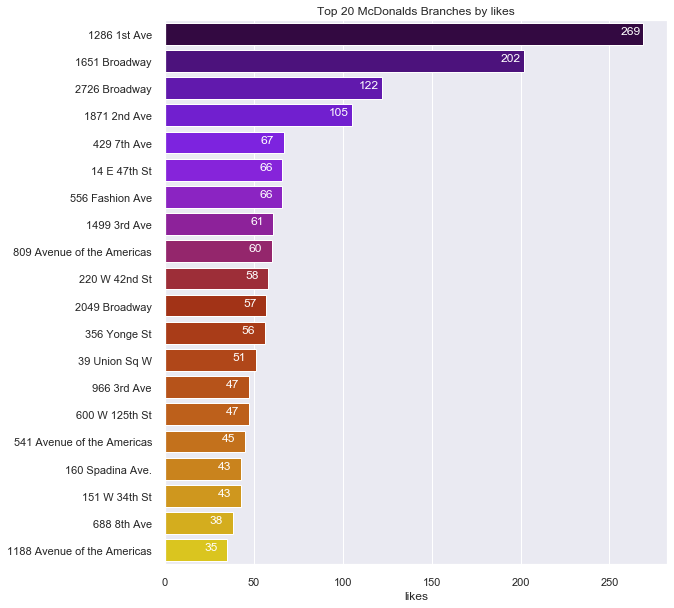

In [77]:
sns.set(rc={'figure.figsize':(9,10)})

ax = sns.barplot(x='likes', y='address', data=top, palette="gnuplot")
ax.set_title('Top 20 McDonalds Branches by likes')
ax.set_ylabel('');

for index, value in enumerate(top['likes']): 
    label = format(value) 
    plt.annotate(label, xy=(value - 13, index - 0.0), color='white')
    
      

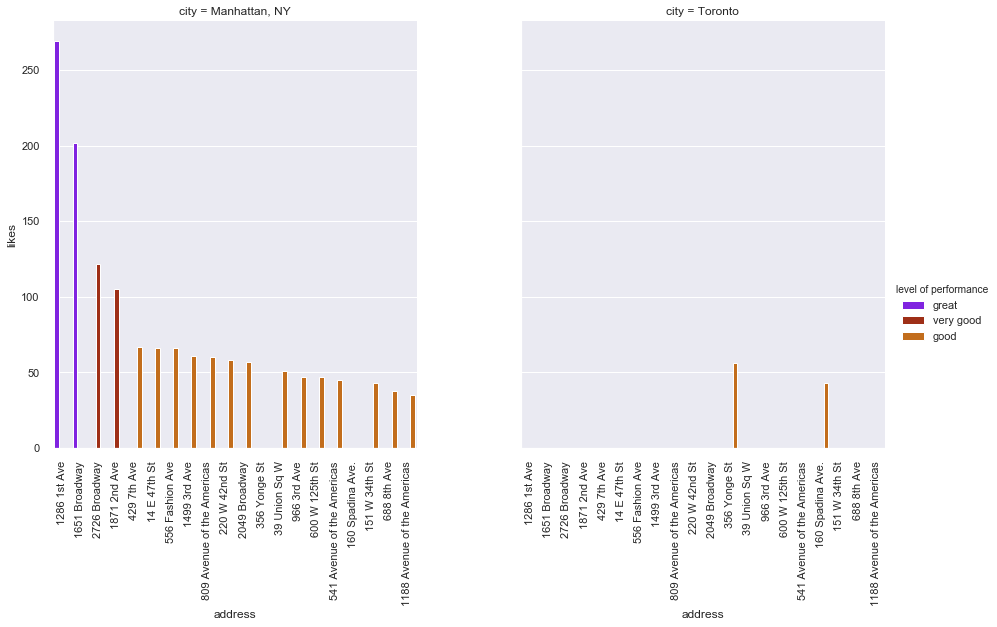

In [78]:
ax = sns.catplot(x="address", y="likes", 
                 col="city", data=top, 
                 kind="bar", hue="level of performance",
                 palette="gnuplot",height=7, aspect=.9
)

ax.set_xticklabels(rotation=90) 

## Worst twenty branches of the chain in Manhattan and Toronto

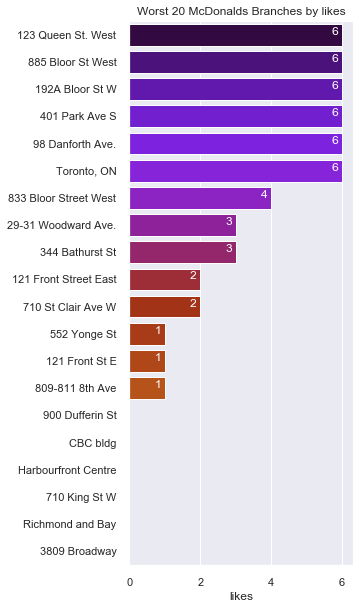

In [79]:
sns.set(rc={'figure.figsize':(4,10)})

ax = sns.barplot(x='likes', y='address', data=worst, palette="gnuplot")
ax.set_title('Worst 20 McDonalds Branches by likes')
ax.set_ylabel('');

for index, value in enumerate(worst['likes']): 
    label = format(value) 
    plt.annotate(label, xy=(value - 0.3, index - 0.0), color='white')

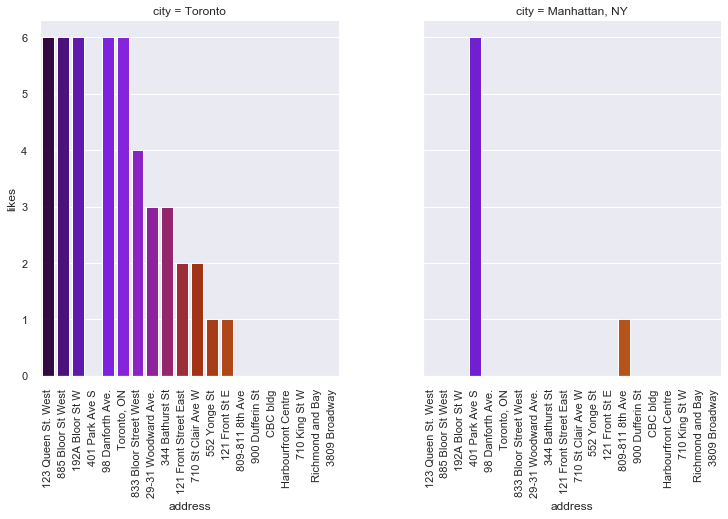

In [80]:
ax = sns.catplot(x="address", y="likes", 
                 col="city", data=worst, 
                 kind="bar", 
                 palette="gnuplot",height=6, aspect=.9
)

ax.set_xticklabels(rotation=90) 

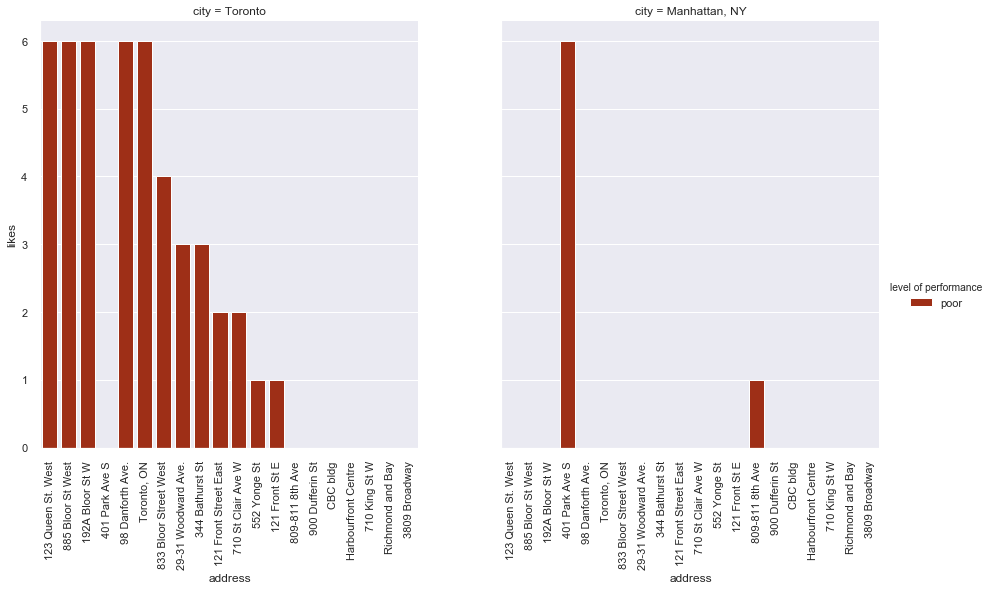

In [81]:
ax = sns.catplot(x="address", y="likes", 
                 col="city", data=worst, 
                 kind="bar", hue="level of performance",
                 palette="gnuplot",height=7, aspect=.9
)

ax.set_xticklabels(rotation=90) 